# Imports

In [335]:
import random
import pandas as pd
import numpy as np
from PIL import Image
import pathlib

import torch, torchvision
from torchvision.io import read_image
from torchvision.models import resnet34
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

random.seed(2023)
import warnings
warnings.filterwarnings('ignore')

# Download

In [323]:
import gdown # модуль для загрузки с гугл-диска
url = 'https://drive.google.com/uc?id=1ONrKzVseOn8ZjBSK28VCh0bDYDrbun4k&confirm=y' # адрес
#https://drive.google.com/file/d/1ONrKzVseOn8ZjBSK28VCh0bDYDrbun4k/view?usp=share_link
output = 'archive.zip' # название загружаемого файла
gdown.download(url, output, quiet=False) # загружаем
!echo "Downloading image"
# распаковываем
!unzip -o -qq archive.zip
# удаляем после распаковки
!ls
root = './image/Google/' # директория с файлами 

Downloading...
From: https://drive.google.com/uc?id=1ONrKzVseOn8ZjBSK28VCh0bDYDrbun4k&confirm=y
To: /content/archive.zip
100%|██████████| 49.9M/49.9M [00:00<00:00, 194MB/s]


archive.zip  full_emoji.csv  image  sample_data


# 1. Распознавание

In [324]:
class IMG_dataset(Dataset):
    # кастомный датасет для ряботы с pytorch dataloader
    def __init__(self, csv_file, root_dir):
        
        self.path = root_dir
        self.classes = {
            0: 'face',
            1: 'person',
            2: 'flag',
            3: 'other'
        }
        self.data = list()

        for num, name in zip(csv_file['#'], csv_file['name']):
            if 'face' in name:
                self.data.append((0, num))
                continue
            if 'person' in name:
                self.data.append((1, num))
                continue
            if 'flag' in name:
                self.data.append((2, num))
                continue
            self.data.append((3, num))

    def __getitem__(self, idx):

        tscp = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor()
        ])

        curr = self.data[idx]
        path = self.path + '/' + str(curr[1]) + '.png'  
        img = Image.open(path).convert('RGBA')
        img  = tscp(img)
        return curr[0], img
        
    def __len__(self):
        return len(self.data)

In [325]:
def train_loop(model, train_data, test_data, EPOCH, batch_size):
    # основная функция обучения, упрощает эксперименты с моделями и параметрами
    load_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    load_test = DataLoader(test_data, batch_size=batch_size)

    history_loss = []
    history_acc = []

    DEVICE = torch.device('cuda')
    criterion = torch.nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ExponentialLR(optim, gamma=0.7)

    for epoch in range(EPOCH):

        ep_tr_loss = []
        ep_tr_acc = []

        ep_test_loss = []
        ep_test_acc = []

        model.cuda().train()
        for by, bx in load_train:

            bx = bx.cuda()
            by = by.type(torch.LongTensor)

            optim.zero_grad()
            preds = model(bx)
            loss = criterion(preds.cpu(), by)
            loss.backward()
            optim.step()

            ep_tr_loss.append(loss.item())
            sm = torch.nn.Softmax(dim=1)
            preds = torch.argmax(sm(preds.detach().cpu()), dim=1)
            by = by.numpy()
            ep_tr_acc.append(accuracy_score(by, preds))
        scheduler.step()
        
        model.eval()
        for by, bx in load_test:

            bx = bx.cuda()
            by = by.type(torch.LongTensor)

            with torch.no_grad():
                preds = model(bx)
            
            preds = preds.cpu()
            loss = criterion(preds, by)

            ep_test_loss.append(loss.item())
            sm = torch.nn.Softmax(dim=1)
            preds =  torch.argmax(sm(preds.detach().cpu()), dim=1)
            ep_test_acc.append(accuracy_score(by, preds))
        
        loss1 = round(sum(ep_tr_loss) / len(ep_tr_loss), 4)
        acc1 = round(sum(ep_tr_acc) / len(ep_tr_acc), 4)
        loss2 = round(sum(ep_test_loss) / len(ep_test_loss), 4)
        acc2 = round(sum(ep_test_acc) / len(ep_test_acc), 4)
        print(f'epoch {epoch}: train loss {loss1}, train acc {acc1}, test loss {loss2}, test acc {acc2}')

        history_loss.extend(ep_test_loss)
        history_acc.extend(ep_test_acc)

    return history_loss, history_acc

In [353]:
data = pd.read_csv('/content/full_emoji.csv')
data = data[['#', 'name']]
data = data.sample(frac=1, random_state=2023, ignore_index=True)
data.head()

,#,name
0,838,hot springs
1,1699,flag: Monaco
2,512,gorilla
3,89,weary face
4,1331,wheelchair symbol


In [354]:
ind = 0
while ind != len(data):

    if not pathlib.Path(f'/content/image/Apple/{data.iloc[ind][0]}.png').exists():
        data = data.drop(labels=ind, axis=0)
        data = data.reset_index(drop=True)
        print('check')
        continue
    ind += 1

check
check
check


In [328]:
PATH = '/content/image/Apple'

test_size = round(len(data) * 0.3)
test = pd.DataFrame(data.iloc[:test_size]).reset_index(drop=True)
train = pd.DataFrame(data.iloc[test_size:]).reset_index(drop=True)

test_data = IMG_dataset(test, PATH)
train_data = IMG_dataset(train, PATH)

In [329]:
model = resnet34(weights='ResNet34_Weights.IMAGENET1K_V1')
model.conv1 = torch.nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = torch.nn.Linear(in_features=512, out_features=4, bias=True)

In [330]:
history_loss, history_acc = train_loop(model, train_data, test_data, 5, 32)

epoch 0: train loss 0.4772, train acc 0.8679, test loss 0.3911, test acc 0.9062
epoch 1: train loss 0.3081, train acc 0.9254, test loss 0.3618, test acc 0.8842
epoch 2: train loss 0.2316, train acc 0.9417, test loss 0.2166, test acc 0.9357
epoch 3: train loss 0.1902, train acc 0.9461, test loss 0.2085, test acc 0.9467
epoch 4: train loss 0.1755, train acc 0.948, test loss 0.1735, test acc 0.9467


# 2. Атаки 

In [331]:
# таки будм производить методом one-pixel-attack
# удобнее всего будет реализовать это через библиотеку ниже
# с основными принципами этого метода я ознакомился по ссылке: 
# https://habr.com/ru/post/498114/
# ссылка на библиотеку (она основана на методах, которые используют в статье)
# https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html

!pip install torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [332]:
from torchattacks.attacks.onepixel import OnePixel

In [360]:
# вместо списка имен берем путь к изображению для простоты реализации

def attack_emoji(path, model, pixels, steps):

    classes = {
            0: 'face',
            1: 'person',
            2: 'flag',
            3: 'other'
        }

    tscp = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor()
        ])
    img = Image.open(path).convert('RGBA')
    img_c = tscp(img)
    model.cuda()
    img_c = torch.unsqueeze(img_c, 0).cuda()
    with torch.no_grad():
                labels = model(img_c)
    model.cpu()
    labels = labels.detach().cpu()
    t = torch.nn.Softmax(1)
    labels = t(labels)
    pred = torch.argmax(labels, 1)
    print(f'clear image pred - {classes[pred.item()]}')

    attack = OnePixel(model=model, pixels=pixels, steps=steps)
    adv_images = attack(img_c.cuda(), pred.cuda())
    img_c, pred = img_c.detach().cpu(), pred.detach().cpu()
    
    model.cuda()
    adv_images = adv_images.cuda()
    with torch.no_grad():
                noised = model(adv_images)
    model.cpu()
    adv_images = adv_images.cpu()
    noised = noised.detach().cpu()
    noised = t(noised)
    noised = torch.argmax(noised, 1)
    print(f'noised image pred - {classes[noised.item()]}')

    plt.figure()
    plt.imshow(img)

    plt.figure()
    transform = torchvision.transforms.ToPILImage()
    adv_images = adv_images[0].permute(1, 2, 0)
    plt.imshow(adv_images)

clear image pred - other
noised image pred - flag


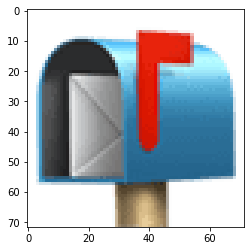

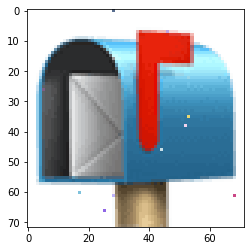

In [361]:
PATH = '/content/image/Apple/1221.png'
attack_emoji(PATH, model, 10, 10)

In [362]:
# пришлось пару минут поперебирать файлы, чтобы найти подходящий сэмпл
# опираясь на оценку качества атак в статье на хабре (таблица в конце), я думаю
# это связано с не самыми оптимальными параметрами для конкретного датасета и модели
# (качество атак может колебаться в районе 30%)